# Classificação com conjunto completo de dados

Finalmente, a última fase da nossa solução envolve, como já adiantado, treinar e utilizar os diferentes modelos de classificação com o conjunto completo de dados (saído do pré-processamento), cingindo os valores para os diferentes parâmetros àqueles que foram obtidos, na fase anterior, como os melhores para cada modelo.

Seguem-se as importações necessárias e o carregamento dos conjuntos de dados.

In [407]:
import pandas as pd
import json
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from joblib import parallel_backend
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

galaxy_data = pd.read_csv("data/clean_data.csv")
all_inputs = galaxy_data.drop(columns=["subclass"]).values

galaxy_data_normalized = pd.read_csv("data/clean_data_normalized.csv")
all_inputs_normalized = galaxy_data_normalized.drop(columns=["subclass"]).values

all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

## Definição de estruturas e funções

### Conjuntos de treino e de teste

In [408]:
(
    training_inputs, 
    testing_inputs, 
    training_classes, 
    testing_classes
) = train_test_split(all_inputs, all_labels, test_size=0.25)

### Conjuntos de treino e de teste entre os dados normalizados

In [409]:
(
    training_inputs_normalized,
    testing_inputs_normalized,
    training_classes_normalized,
    testing_classes_normalized,
) = train_test_split(all_inputs_normalized, all_labels, test_size=0.25)

### _Undersampler_ e _oversampler_

In [410]:
under_sampler = RandomUnderSampler()
training_inputs_under_sampl_normalized, training_classes_under_sampl_normalized = under_sampler.fit_resample(
    training_inputs_normalized, training_classes_normalized
)
testing_inputs_under_sampl_normalized = testing_inputs_normalized
testing_classes_under_sampl_normalized = testing_classes_normalized

In [411]:
over_sampler = SMOTE() # RandomOverSampler()

training_inputs_over_sampl_normalized, training_classes_over_sampl_normalized = over_sampler.fit_resample(
    training_inputs_normalized, training_classes_normalized
)
testing_inputs_over_sampl_normalized = testing_inputs_normalized
testing_classes_over_sampl_normalized = testing_classes_normalized

Segue-se a importação das combinações de parâmetros obtidas na fase anterior, guardadas no ficheiro `best_params.json`.

In [412]:
def json_to_dict(filename):
    with open(filename, "r") as f:
        return json.load(f)

best_params = json_to_dict("best_params.json")

Segue-se, ainda, uma função que invoca o treino de um dado modelo de classificação.

In [413]:
def train_classifier(
    classifier,
    data,
    labels,
):
    with parallel_backend("loky"):
        classifier.fit(data, labels)
    print("Classifier trained")

    return classifier

Bem como uma função que dá a conhecer um relatório de _performance_ de um dado modelo:

In [414]:
def print_classification_report(
    model, testing_inputs, testing_classes, filename=None, show_feature_importances=True
):
    # plot histogarm with feature importance
    if show_feature_importances:
        plt.bar(
            galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_
        )
        plt.xticks(rotation=90)
        if filename:
            plt.savefig("images_complete/" + "feature_importances_" + filename, bbox_inches="tight")

    predictions = model.predict(testing_inputs)
    print(classification_report(testing_classes, predictions))

    cf_matrix = confusion_matrix(testing_classes, predictions)
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()

    if filename:
        
        plt.savefig("images_complete/" + filename, bbox_inches="tight")
    plt.show()


## Modelos de Classificação

### _Decision Tree_

O processo é simples: lê-se a combinação de parâmetros, segundo a qual se instancia o classificador, que é treinado segundo os conjuntos de treino definidos anteriormente:

In [415]:
decision_tree_classifier = DecisionTreeClassifier(
    **best_params["Decision Tree"]
)

trained_decision_tree = train_classifier(
    decision_tree_classifier,
    training_inputs,
    training_classes,
)

Classifier trained


É então hora de conhecer a sua _performance_: numa tabela, as habituais medidas, acompanhadas de uma _confusion matrix_ para a classificação:

              precision    recall  f1-score   support

   STARBURST       0.75      0.70      0.72      6045
 STARFORMING       0.90      0.92      0.91     18325

    accuracy                           0.87     24370
   macro avg       0.83      0.81      0.82     24370
weighted avg       0.86      0.87      0.87     24370



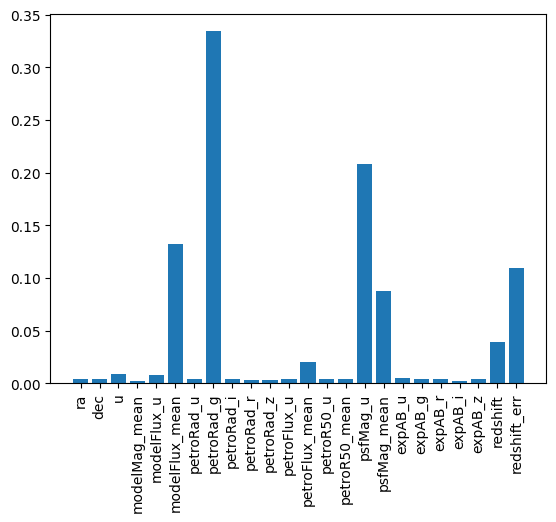

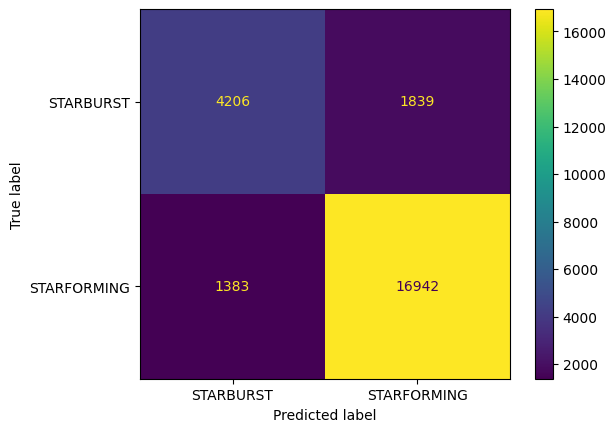

In [416]:
print_classification_report(trained_decision_tree, testing_inputs, testing_classes, "decision_tree.png")

>**O processo é completamente análogo para os restantes modelos, pelo que se omite um acompanhamento textual passo-a-passo como até este ponto.**

### K-NN: Nearest Neighbour

In [417]:
nearest_neighbour = KNeighborsClassifier(
    **best_params["KNN"]
)

trained_nearest_neighbour = train_classifier(
    nearest_neighbour,
    training_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
)

# trained_nearest_neighbour = train_classifier(
#     nearest_neighbour,
#     training_inputs_under_sampl_normalized,
#     training_classes_under_sampl_normalized,
# )

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.59      0.82      0.68      5894
 STARFORMING       0.93      0.82      0.87     18476

    accuracy                           0.82     24370
   macro avg       0.76      0.82      0.78     24370
weighted avg       0.85      0.82      0.83     24370



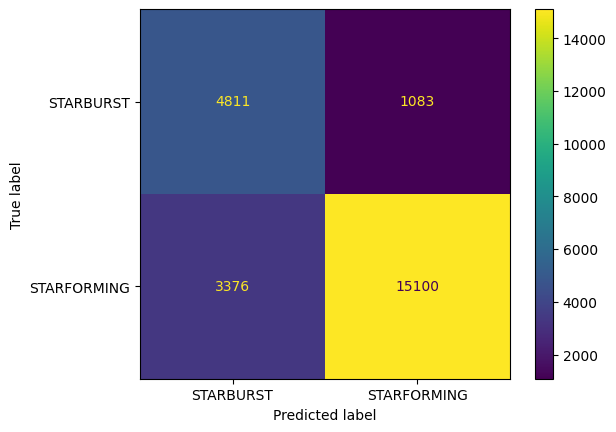

In [418]:
# print_classification_report(trained_nearest_neighbour, testing_inputs_under_sampl_normalized, testing_classes_under_sampl_normalized, "nearest_neighbour.png", False)
print_classification_report(trained_nearest_neighbour, testing_inputs_over_sampl_normalized, testing_classes_over_sampl_normalized, "nearest_neighbour.png", False)

### SVM: Support Vector Machine

In [419]:
svm = SVC(
    max_iter=100000,
    **best_params["SVM"]
)

trained_svm = train_classifier(
    svm,
    training_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
)

# trained_svm = train_classifier(
#     svm,
#     training_inputs_under_sampl_normalized,
#     training_classes_under_sampl_normalized,
# )

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.69      0.88      0.77      5894
 STARFORMING       0.96      0.87      0.91     18476

    accuracy                           0.87     24370
   macro avg       0.82      0.88      0.84     24370
weighted avg       0.89      0.87      0.88     24370



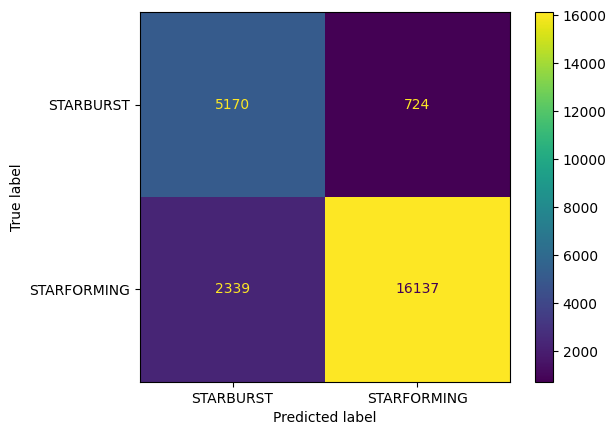

In [420]:
# print_classification_report(trained_svm, testing_inputs_under_sampl_normalized, testing_classes_under_sampl_normalized, "svm.png", False)
print_classification_report(trained_svm, testing_inputs_over_sampl_normalized, testing_classes_over_sampl_normalized, "svm.png", False)

### Redes Neuronais

In [421]:
neural_networks = MLPClassifier(
    **best_params["Neural Network"]
)

trained_neural_networks = train_classifier(
    neural_networks,
    training_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
)

# trained_neural_networks = train_classifier(
#     neural_networks,
#     training_inputs_under_sampl_normalized,
#     training_classes_under_sampl_normalized,
# )

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.72      0.86      0.78      5894
 STARFORMING       0.95      0.89      0.92     18476

    accuracy                           0.88     24370
   macro avg       0.83      0.87      0.85     24370
weighted avg       0.89      0.88      0.89     24370



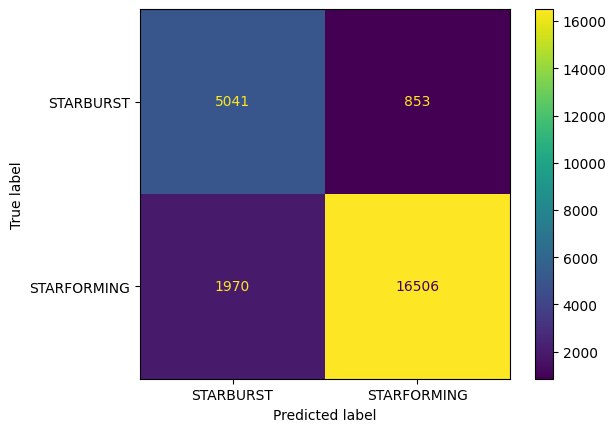

In [422]:
# print_classification_report(trained_neural_networks,
#     testing_inputs_under_sampl_normalized,
#     testing_classes_under_sampl_normalized,
#     "neural_networks.png",
#     False
# )

print_classification_report(
    trained_neural_networks,
    testing_inputs_over_sampl_normalized,
    testing_classes_over_sampl_normalized,
    "neural_networks.png",
    False
)

### Random Forest

In [423]:
random_forest = RandomForestClassifier(
    **best_params["Random Forest"]
)

trained_random_forest = train_classifier(
    random_forest,
    training_inputs,
    training_classes,
)

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.82      0.71      0.76      6045
 STARFORMING       0.91      0.95      0.93     18325

    accuracy                           0.89     24370
   macro avg       0.86      0.83      0.84     24370
weighted avg       0.89      0.89      0.89     24370



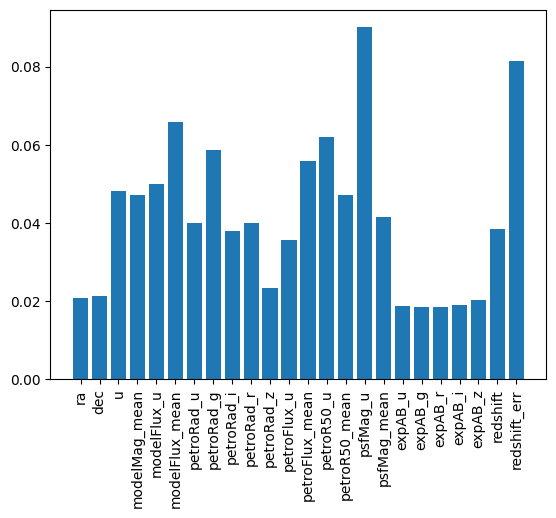

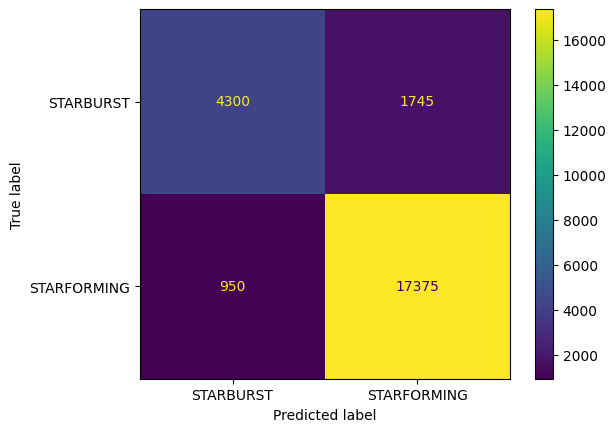

In [424]:
print_classification_report(trained_random_forest, testing_inputs, testing_classes, "random_forest.png")

Os gráficos gerados ao longo do processo são gravados no diretório `images_complete`.